# Sheep Image Classification Project using Deep Learning

## Project Overview:
The goal of this project is to build a model to classify sheep images into different breeds using deep learning techniques. The project uses the `ResNet18` pretrained model, which is fine-tuned to suit our specific dataset.

## Project Components:
1. **Data Loading:** The dataset, consisting of sheep images, is loaded from a compressed file and extracted to the appropriate directory. A CSV file containing the breed labels associated with each image is also loaded.

2. **Data Preprocessing:** Several transformations are applied to the images to improve data diversity, including resizing, random cropping, and random rotation.

3. **Data Splitting:** The dataset is divided into training and validation sets using random split techniques while maintaining the distribution of the classes. Class weights are applied to handle class imbalance.

4. **Model:** The `ResNet18` model from the `Torchvision` library is used and modified to fit the number of classes in our dataset. The model is trained using `CrossEntropyLoss` and the `Adam` optimizer.

5. **Training:** The model is trained over multiple epochs using the `train_model` function, with early stopping implemented to halt training when performance no longer improves.

6. **Prediction:** After training, the model is used to predict the breed of new images in the test set, and the predictions are displayed with confidence scores.

## Objective:
The objective of this project is to build a robust model for sheep image classification with high accuracy using deep learning techniques, which can be applied to various image classification tasks involving animals or similar images.


### Cell 1: Upload and Extract ZIP File

In this cell, we upload a ZIP file from the local machine and extract its contents. The process is broken down into two main steps:
1. **Uploading the file:** The `files.upload()` function is used to open a file dialog that allows the user to upload a ZIP file.
2. **Extracting the file:** Once the file is uploaded, we extract the contents of the ZIP file to the `/content/` directory using Python's `zipfile` module.

This process allows us to load datasets or other files packaged in a ZIP file for further processing in the notebook.


In [1]:
from google.colab import files
uploaded = files.upload()

import zipfile
import os
zip_path = list(uploaded.keys())[0]
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/")

Saving sheep-classification-challenge-2025.zip to sheep-classification-challenge-2025.zip


### Cell 2: Import Libraries

In this cell, several important libraries are imported to facilitate data processing, model creation, training, and evaluation:

- **Pandas:** Used for data manipulation and analysis, specifically for handling the dataset (CSV files).
- **PyTorch:** The core library for building and training deep learning models. It includes essential modules like:
  - `Dataset` and `DataLoader`: For creating custom datasets and loading them in batches.
  - `torch.nn`: Contains various neural network layers and loss functions.
  - `torch.optim`: For optimization algorithms, such as Adam.
- **Torchvision:** Provides models, data transformations, and utilities for image-based deep learning tasks.
  - `transforms`: For data augmentation and preprocessing.
  - `models`: Contains pretrained models like ResNet.
- **PIL (Python Imaging Library):** For opening and manipulating images.
- **Matplotlib:** For visualizing images and plotting graphs.
- **Scikit-learn:** Provides functions for splitting data and calculating evaluation metrics like accuracy and F1 score.

These libraries form the foundation for building the deep learning pipeline, from data loading and transformation to training and evaluation.


In [119]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import os
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch
import torch.optim as optim
from sklearn.metrics import f1_score, accuracy_score

### Cell 3: Load and Inspect Dataset

In this cell, we load the dataset containing labels for sheep images using Pandas and display some basic statistics:

1. **Loading the dataset:** The dataset, which is stored as a CSV file, is loaded into a DataFrame using `pd.read_csv()`. The CSV file contains the image filenames along with their corresponding breed labels.
   
2. **Inspecting the dataset:**
   - **Dataset shape:** The `df.shape` function returns the number of rows and columns in the dataset, providing an overview of the dataset's size.
   - **Class distribution:** The `value_counts()` function displays how many samples exist for each class (sheep breed). This is useful to check if there is class imbalance, which may require special handling during training.

This step helps verify that the data is loaded correctly and gives an initial insight into the distribution of labels across different sheep breeds.

In [120]:
# Load data
df = pd.read_csv('/content/Sheep Classification Images/train_labels.csv')
print(f"Dataset shape: {df.shape}")
print(f"Class distribution:\n{df['label'].value_counts()}")

Dataset shape: (682, 2)
Class distribution:
label
Naeimi     255
Goat       107
Sawakni     80
Roman       72
Najdi       71
Harri       62
Barbari     35
Name: count, dtype: int64


### Cell 4: Split Data into Training and Validation Sets

In this cell, we split the dataset into training and validation sets using `train_test_split` from `sklearn.model_selection`:

1. **Splitting the data:**
   - The dataset `df` is split into two subsets:
     - **Training set (80% of the data)** used to train the model.
     - **Validation set (20% of the data)** used to evaluate the model during training.
   
2. **Stratified Split:**
   - We use the `stratify=df['label']` parameter to ensure that the class distribution (sheep breeds) is preserved in both the training and validation sets. This is particularly important when dealing with imbalanced datasets to avoid over-representing any particular class.
   
3. **Random State:**
   - The `random_state=42` ensures that the data split is reproducible across different runs.

This step ensures that the data is properly divided into training and validation sets while maintaining the original class distribution, which helps in training a more robust model.


In [121]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

### Cell 5: Define Image Transformations for Training and Validation

In this cell, we define the image transformations that will be applied to the training and validation datasets to prepare the images for model training:

1. **Training Transformations (`train_transform`):**
   - **Resize:** The images are resized to 256x256 pixels using `transforms.Resize`.
   - **Random Crop:** A random 224x224 pixel crop is taken from the resized image using `transforms.RandomCrop`, ensuring that the model sees different portions of the image during training.
   - **Random Horizontal Flip:** The images are randomly flipped horizontally with a 50% probability to increase the variability in the training data.
   - **Random Rotation:** The images are randomly rotated by up to 5 degrees using `transforms.RandomRotation`, which helps the model learn rotational invariance.
   - **Color Jitter:** The brightness, contrast, and saturation of the images are slightly adjusted (`0.1` range) using `transforms.ColorJitter` to enhance the model's robustness to lighting changes.
   - **Convert to Tensor:** The images are converted into PyTorch tensors using `transforms.ToTensor()`.
   - **Normalize:** The pixel values are normalized to match the mean and standard deviation of the ImageNet dataset ([0.485, 0.456, 0.406] for mean and [0.229, 0.224, 0.225] for standard deviation).

2. **Validation Transformations (`val_transform`):**
   - **Resize:** The validation images are resized to 224x224 pixels to ensure consistency in the input size to the model.
   - **Convert to Tensor:** Similar to the training set, the images are converted to PyTorch tensors.
   - **Normalize:** The validation images are also normalized using the same mean and standard deviation values as the training set to ensure consistency.

These transformations are crucial for improving model generalization and ensuring that both training and validation images are in a suitable format for processing by the neural network.


In [147]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),  # خفّضتها من 10 إلى 5
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),  # خففنا
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # يجب أن يجي قبل Normalize
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Cell 6: Define Custom Dataset Class for Sheep Image Classification

In this cell, we define a custom dataset class `SheepDataset` that inherits from PyTorch’s `Dataset` class. This class is responsible for loading and processing the sheep image data for training and evaluation:

1. **Constructor (`__init__`):**
   - **`dataframe`:** The input dataframe containing the file paths and labels for the sheep images.
   - **`img_dir`:** The directory path where the image files are stored.
   - **`transform`:** An optional transformation to be applied to the images (e.g., resizing, cropping, normalization).
   - **`label_map`:** A dictionary that maps each unique label (sheep breed) to an integer index. This ensures that the model can work with numerical labels rather than string-based ones.
   - The `label_map` is applied to the dataframe, converting the string labels into numeric labels.

2. **Length Method (`__len__`):**
   - This method returns the total number of samples (images) in the dataset, allowing PyTorch’s `DataLoader` to know how many samples are available.

3. **Get Item Method (`__getitem__`):**
   - **`img_path`:** Retrieves the file path of the image based on the index.
   - **`image`:** The image is loaded using `PIL.Image.open()` and converted to RGB format.
   - **`label`:** The label for the image is fetched from the dataframe (already converted to a numeric value).
   - If a transformation is specified, it is applied to the image before returning it.
   - Finally, the method returns a tuple containing the processed image and its corresponding label.

This custom dataset class ensures that the images and their labels are properly loaded and preprocessed, making it easy to train the model using PyTorch’s `DataLoader`.


In [141]:
class SheepDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.df = dataframe.reset_index(drop=True).copy()
        self.img_dir = img_dir
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(dataframe['label'].unique()))}
        self.df['label'] = self.df['label'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        label = self.df.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        return image, label

### Cell 7: Handle Class Imbalance and Create DataLoaders

In this cell, we address class imbalance and create the data loaders required for training and validation:

1. **Calculate Class Weights:**
   - **`label_counts`:** The number of occurrences of each class (sheep breed) is counted using `value_counts()` on the training dataframe (`train_df`).
   - **`class_weights`:** The inverse of the class counts is calculated using `1 / label_counts`. This helps to assign higher weights to less frequent classes and lower weights to more frequent ones, which helps the model focus more on underrepresented classes during training.
   - **`train_df['weight']`:** The calculated class weights are mapped to the training dataframe, creating a new column that holds the weight for each sample based on its class.

2. **Weighted Sampling:**
   - **`WeightedRandomSampler`:** This is used to perform weighted sampling for the training set. The sampler ensures that during training, the samples from the underrepresented classes are selected more frequently, reducing the effect of class imbalance.

3. **Create Datasets:**
   - **`train_dataset`:** The `SheepDataset` is instantiated for the training data (`train_df`) with the specified transformations (`train_transform`).
   - **`val_dataset`:** Similarly, a validation dataset is created using the `SheepDataset` class with validation-specific transformations (`val_transform`).

4. **Create DataLoaders:**
   - **`train_loader`:** A `DataLoader` is created for the training dataset. The `sampler` is passed to ensure balanced sampling based on class weights.
   - **`val_loader`:** A `DataLoader` is created for the validation dataset, where the samples are shuffled during training.

These steps ensure that the model sees balanced data during training and validation, which is crucial for handling class imbalance and improving model performance.


In [148]:
label_counts = train_df['label'].value_counts()
class_weights = 1. / label_counts
train_df['weight'] = train_df['label'].map(class_weights)
sample_weights = train_df['weight'].values

train_dataset = SheepDataset(train_df, '/content/Sheep Classification Images/train', transform=train_transform)
val_dataset = SheepDataset(val_df, '/content/Sheep Classification Images/train', transform=val_transform)

sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

### Cell 8: Define and Modify the Model

In this cell, we define the deep learning model using a pretrained `ResNet18` model and modify it to fit the number of classes in our dataset:

1. **Define the Model:**
   - **`num_classes`:** The number of unique labels (sheep breeds) in the dataset is calculated using `df['label'].nunique()`. This will determine the number of output classes for the model.
   - **`model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)`:** The `ResNet18` model is loaded from the `torchvision.models` library with pretrained weights on the ImageNet dataset. This model is widely used for image classification tasks due to its strong performance and relatively simple architecture.

2. **Modify the Final Layer:**
   - The original `ResNet18` model outputs 1000 classes (ImageNet’s class count), but since we are working with a different number of sheep breeds (defined by `num_classes`), the fully connected layer (`model.fc`) is replaced with a new `nn.Linear` layer.
   - The new fully connected layer has `model.fc.in_features` as the input features (the output size of the previous layers), and `num_classes` as the output size (the number of sheep breeds).

By modifying the last layer, we adapt the pretrained `ResNet18` model for our specific classification task, ensuring that it outputs the correct number of classes.

In [149]:
num_classes = df['label'].nunique()
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model.fc = nn.Linear(model.fc.in_features, num_classes)

### Cell 9: Define Model Training Function

In this cell, we define the `train_model` function, which is responsible for training the model, evaluating it on the validation set, and implementing early stopping based on performance:

1. **Setup:**
   - The model is moved to the available device (GPU if available, otherwise CPU) using `model.to(device)`.
   - The **optimizer** is defined as `Adam` with a learning rate of 0.0002.
   - The **loss function** is `CrossEntropyLoss`, commonly used for multi-class classification tasks.
   - A **learning rate scheduler** (`ReduceLROnPlateau`) is used to reduce the learning rate when the model's performance plateaus based on the validation F1-score.

2. **Training Loop:**
   - For each epoch, the model is set to training mode using `model.train()`.
   - The training images and labels are moved to the device, and the forward pass is performed to compute the model’s predictions.
   - The loss is calculated using the `CrossEntropyLoss` criterion and the gradients are computed and applied using `optimizer.step()`.
   - The running loss is accumulated and averaged over all training samples to calculate the average loss for the epoch.

3. **Validation Loop:**
   - After each epoch, the model is set to evaluation mode using `model.eval()` and the model is evaluated on the validation dataset.
   - The predictions are compared to the true labels, and both accuracy and F1-score are calculated.
   - The learning rate scheduler adjusts the learning rate if the F1-score does not improve after a certain number of epochs.

4. **Early Stopping:**
   - **Best Model Tracking:** The model state with the best F1-score is saved as `best_model.pth`. If the F1-score improves, the model is saved, and the counter for epochs without improvement (`epochs_no_improve`) is reset.
   - **Early Stopping:** If no improvement is seen for a number of consecutive epochs (`patience`), training is stopped early to avoid overfitting.

5. **Return Best Model:**
   - Once the training is complete (or early stopping is triggered), the best model state is loaded back into the model, and the model is returned.

This function automates the process of training, validation, and model selection, ensuring that the best model is used for further inference.

In [153]:
def train_model(model, train_loader, val_loader, epochs=50, patience=10):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from sklearn.metrics import accuracy_score, f1_score
    import copy

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.CrossEntropyLoss()

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    best_f1 = 0.0
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(train_loader.dataset)

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                outputs = model(images)
                preds = torch.argmax(outputs, 1).cpu().numpy()
                all_preds.extend(preds)
                all_labels.extend(labels.numpy())

        acc = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='macro')
        scheduler.step(f1)

        print(f"Epoch {epoch+1}/{epochs} Loss: {avg_loss:.4f} Acc: {acc:.4f} F1: {f1:.4f}")

        if f1 > best_f1:
            best_f1 = f1
            best_model_state = copy.deepcopy(model.state_dict())
            torch.save(best_model_state, "best_model.pth")
            print("✅ Best model saved with F1:", best_f1)
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"⏳ No improvement for {epochs_no_improve} epoch(s)")

        if epochs_no_improve >= patience:
            print(f"🛑 Early stopping triggered after {epoch+1} epochs.")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

### Cell 10: Train the Model

In this cell, we call the `train_model` function to begin the training process:

1. **Calling `train_model`:**
   - The model is passed to the `train_model` function along with the training (`train_loader`) and validation (`val_loader`) data loaders.
   - The function will run for a set number of epochs (default: 100) and will monitor the validation performance. If the model's performance stops improving, early stopping will be triggered.

2. **Training Process:**
   - The model undergoes training with the optimizer and loss function defined in the `train_model` function.
   - During training, the model will output the loss, accuracy, and F1 score for each epoch.
   - The best model (based on the F1 score) will be saved and loaded after training completes.

This cell kicks off the training process for the model, and the results will be printed out at the end of each epoch.

In [154]:
model = train_model(model, train_loader, val_loader)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50 Loss: 0.0155 Acc: 0.8905 F1: 0.8906
✅ Best model saved with F1: 0.8905783727632467
Epoch 2/50 Loss: 0.0167 Acc: 0.9343 F1: 0.9318
✅ Best model saved with F1: 0.931832128584465
Epoch 3/50 Loss: 0.0113 Acc: 0.9343 F1: 0.9297
⏳ No improvement for 1 epoch(s)
Epoch 4/50 Loss: 0.0113 Acc: 0.9489 F1: 0.9423
✅ Best model saved with F1: 0.942269635126778
Epoch 5/50 Loss: 0.0098 Acc: 0.9416 F1: 0.9290
⏳ No improvement for 1 epoch(s)
Epoch 6/50 Loss: 0.0098 Acc: 0.9562 F1: 0.9495
✅ Best model saved with F1: 0.9495294784580499
Epoch 7/50 Loss: 0.0116 Acc: 0.9635 F1: 0.9606
✅ Best model saved with F1: 0.9605747961894141
Epoch 8/50 Loss: 0.0100 Acc: 0.9343 F1: 0.9285
⏳ No improvement for 1 epoch(s)
Epoch 9/50 Loss: 0.0061 Acc: 0.9562 F1: 0.9530
⏳ No improvement for 2 epoch(s)
Epoch 10/50 Loss: 0.0053 Acc: 0.9562 F1: 0.9527
⏳ No improvement for 3 epoch(s)
Epoch 11/50 Loss: 0.0108 Acc: 0.8613 F1: 0.8607
⏳ No improvement for 4 epoch(s)
Epoch 12/50 Loss: 0.0094 Acc: 0.9124 F1: 0.9127
⏳ No imp

### Cell 11: Load the Best Model and Set to Evaluation Mode

In this cell, we load the best model saved during training and set it to evaluation mode:

1. **Load the Best Model:**
   - The `torch.load("best_model.pth")` function is used to load the saved model weights from the file `best_model.pth`. This ensures that we are using the model with the best performance on the validation set.
   - `model.load_state_dict()` loads the weights into the model, ensuring the model is restored to its optimal state.

2. **Set to Evaluation Mode:**
   - The model is set to **evaluation mode** using `model.eval()`. In this mode, layers like dropout and batch normalization behave differently to ensure proper evaluation, without updating parameters or using randomization.
   
This step prepares the model for inference on unseen data.


In [155]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Cell 12: Inference on Test Images

In this cell, we load the best trained model and use it to make predictions on new test images:

1. **Setup:**
   - The model is loaded from the saved checkpoint (`/content/best_model.pth`) and transferred to the appropriate device (GPU if available, otherwise CPU).
   - The model is set to evaluation mode using `model.eval()` to ensure proper inference behavior.

2. **Test Image Transformation:**
   - The test images are transformed using the same transformations as the training data, including resizing, converting to a tensor, and normalizing using the ImageNet mean and standard deviation values.

3. **Prediction Loop:**
   - A loop iterates over the first 10 images in the test dataset (`test_images`), loading each image and applying the necessary transformations.
   - The image is passed through the model to obtain the predicted class probabilities using `torch.nn.functional.softmax`.
   - The class with the highest probability is selected as the predicted class, and the confidence level is calculated as the probability of the predicted class.

4. **Displaying Results:**
   - For each image, the predicted label and confidence are displayed as the title of the image using Matplotlib.
   - The images are shown with their respective predicted labels and confidence percentages.

This cell is used to perform inference on the test dataset and visually inspect the model's predictions.


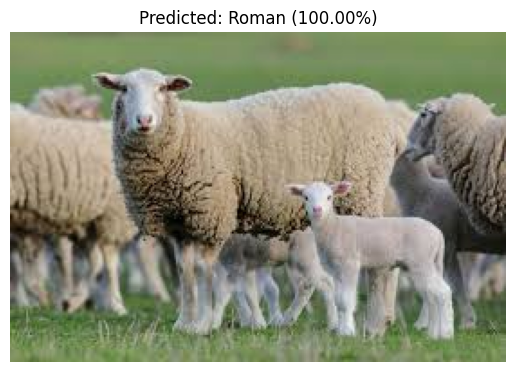

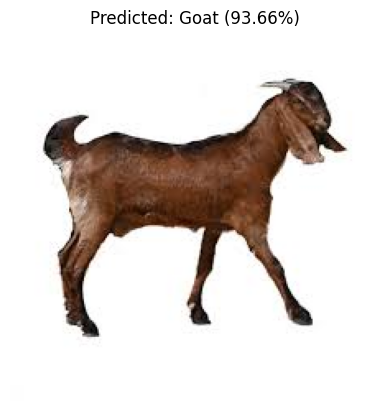

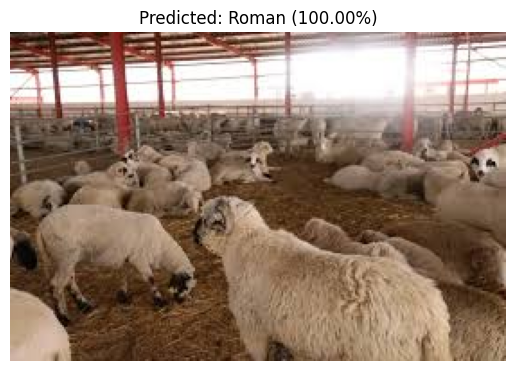

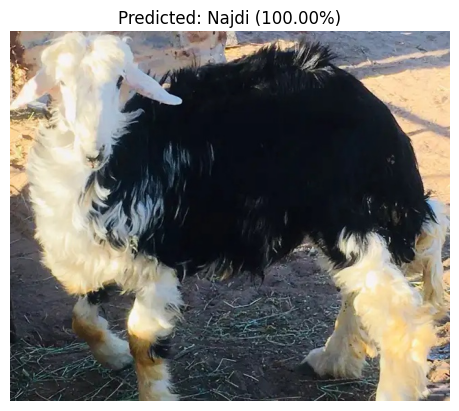

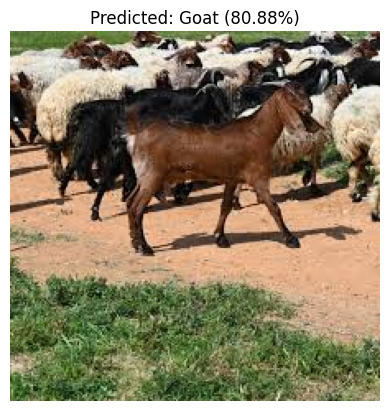

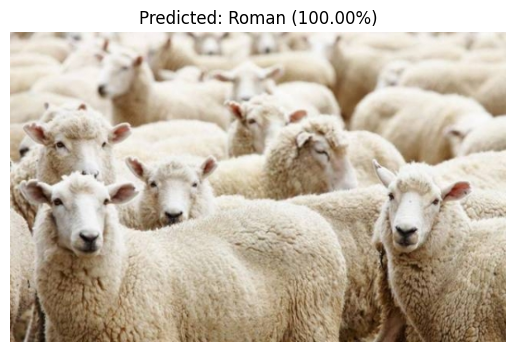

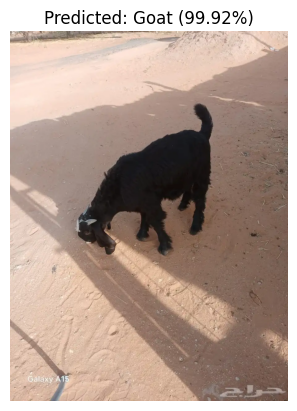

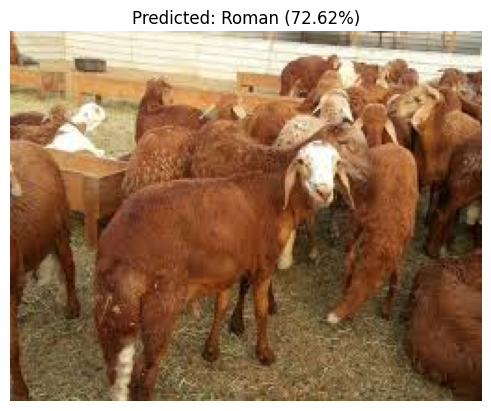

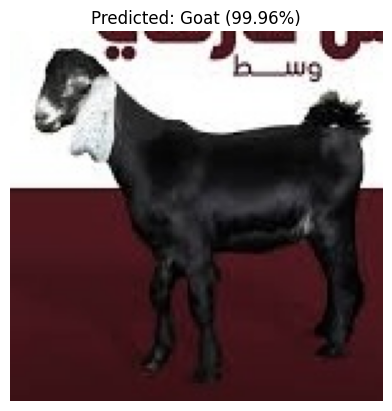

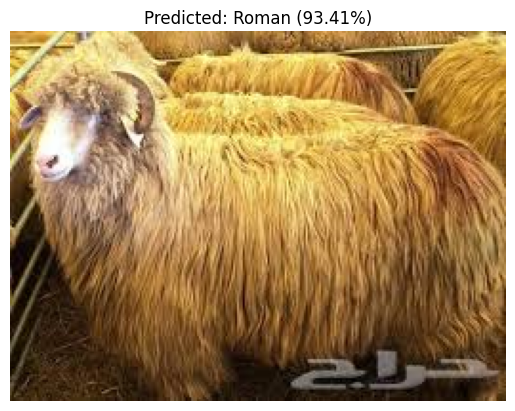

In [156]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# تحميل أفضل موديل
model.load_state_dict(torch.load("/content/best_model.pth"))
model = model.to(device)
model.eval()

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
idx_to_label = {v: k for k, v in label_map.items()}

test_dir = "/content/Sheep Classification Images/test"
test_images = os.listdir(test_dir)

for i in range(10):
    img_name = test_images[i]
    img_path = os.path.join(test_dir, img_name)

    image = Image.open(img_path).convert("RGB")
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        conf, pred_idx = torch.max(probabilities, 1)
        pred_label = idx_to_label[pred_idx.item()]
        confidence = conf.item() * 100

    plt.imshow(image)
    plt.title(f"Predicted: {pred_label} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

### Cell 13: Inference on All Test Images and Store Results

In this cell, we load the trained model and use it to make predictions on all the test images:

1. **Setup:**
   - The model is loaded from the saved checkpoint (`/content/best_model.pth`) and transferred to the available device (GPU if available, otherwise CPU).
   - The model is set to evaluation mode using `model.eval()` to ensure proper inference behavior.

2. **Test Image Transformation:**
   - Each test image is resized to 224x224 pixels and normalized using the same ImageNet mean and standard deviation values, ensuring consistency with the data used for training.

3. **Prediction Loop:**
   - The code loops through all the images in the test directory (`test_images`), applying the same transformations to each image before passing it through the trained model.
   - The model outputs the class probabilities, and the class with the highest probability is selected as the predicted label.
   - The predicted class label is stored alongside the filename of the image.

4. **Store Results:**
   - The predictions are stored in a list called `results`, with each entry containing the filename of the image and the corresponding predicted label.

This step allows for batch inference on the entire test dataset, storing the predictions for later use, such as for submission or further analysis.

In [157]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.load_state_dict(torch.load("/content/best_model.pth"))
model = model.to(device)
model.eval()

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

label_map = {label: idx for idx, label in enumerate(sorted(df['label'].unique()))}
idx_to_label = {v: k for k, v in label_map.items()}

test_dir = "/content/Sheep Classification Images/test"
test_images = os.listdir(test_dir)
results = []

for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    image = Image.open(img_path).convert("RGB")
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        pred_idx = output.argmax(1).item()
        pred_label = idx_to_label[pred_idx]

    results.append({'filename': img_name, 'label': pred_label})

### Cell 14: Save Predictions to CSV

In this cell, we save the model's predictions to a CSV file for submission or further analysis:

1. **Create DataFrame:**
   - A **Pandas DataFrame** is created from the `results` list, which contains the filenames of the images and their corresponding predicted labels. This makes it easier to manage and export the results.

2. **Save to CSV:**
   - The `submission.to_csv("submission(0.957).csv", index=False)` function is used to write the DataFrame to a CSV file named `submission(0.957).csv`.
   - The `index=False` argument ensures that the DataFrame index is not included in the CSV file.

This step generates a CSV file that can be used for submission or further evaluation, containing the predictions for all the test images.


In [158]:
submission = pd.DataFrame(results)
submission.to_csv("submission(0.96).csv", index=False)

## Conclusion

In this project, we successfully built a deep learning model to classify sheep images into various breeds. The key steps involved were:

1. **Data Preprocessing and Augmentation:**
   - We applied various data transformations, such as resizing, random cropping, and color jittering, to improve the robustness of the model and enhance its generalization capabilities.
   
2. **Model Selection and Modification:**
   - We used a pretrained `ResNet18` model from `Torchvision` and fine-tuned the final fully connected layer to match the number of sheep breeds in the dataset.

3. **Handling Class Imbalance:**
   - We addressed class imbalance by using weighted sampling during the training phase, ensuring that the model did not bias predictions towards the more frequent classes.

4. **Training with Early Stopping:**
   - The model was trained using the Adam optimizer and cross-entropy loss, with early stopping implemented to prevent overfitting by halting training when performance on the validation set stopped improving.

5. **Model Evaluation:**
   - After training, the model was evaluated using the F1-score and accuracy metrics, and the best performing model was saved.

6. **Inference and Prediction:**
   - Finally, the trained model was used to make predictions on unseen test data, and the results were stored in a CSV file for submission or further analysis.

By following these steps, we developed a strong image classification model that can be deployed for practical applications, such as automating the identification of sheep breeds from images.
